In [3]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, GroupKFold
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [5]:
# 0.1
with open(proj_dir+"latent_space/2023-07-01T00-44-09_sae_kl_f32_ep60.pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [6]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

x = aggregate_embeddings

x = x.reshape(x.shape[0],-1)

In [7]:
print(x.shape)

(1588, 4096)


# Load Trip Behavior

In [8]:
file = "MyDailyTravel/origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)
y_ct = df_pivot['geoid'].to_list()
y = df_pivot[variable_names].to_numpy()[:,:4]

groups = df_pivot['train_test']
group_split = GroupKFold(n_splits=5)

In [9]:
if len(x) != len(y):
    x_mask = [True if c in y_ct else False for c in unique_ct]
    x = x[x_mask,:]
    unique_ct = list(np.array(unique_ct)[x_mask])
    y_mask = [True if c in unique_ct else False for c in y_ct]
    y = y[y_mask,:]
    y_ct = list(np.array(y_ct)[y_mask])

x = x[[y_ct.index(val) for val in unique_ct],:]
unique_ct = list(np.array(unique_ct)[np.array([y_ct.index(val) for val in unique_ct])])
for xc,yc in zip(unique_ct, y_ct):
    assert xc == yc

In [10]:
print(len(y))

1571


# 1. Linear Regression

### 1.1 Auto Share

In [11]:
y_index = 1

In [12]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0067834854125977, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8462905883789062, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.100076675415039, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/s

Parameter: 2.00e-03 	 Train score: 0.7221 	 Cross val score: 0.5601 	 Nonzero coef: 285


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7320327758789062, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48801422119140625, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7788524627685547, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8

Parameter: 3.00e-03 	 Train score: 0.6608 	 Cross val score: 0.5871 	 Nonzero coef: 134


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5004348754882812, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.397216796875, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24050140380859375, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/sit

Parameter: 4.00e-03 	 Train score: 0.6347 	 Cross val score: 0.5931 	 Nonzero coef: 73


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07926750183105469, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19971084594726562, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1325092315673828, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.

Parameter: 5.00e-03 	 Train score: 0.6215 	 Cross val score: 0.5928 	 Nonzero coef: 47


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024379730224609375, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2187519073486328, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16019058227539062, tolerance: 0.007110722362995148
  model = cd_fast.enet_coordinate_descent(


Parameter: 6.00e-03 	 Train score: 0.6142 	 Cross val score: 0.5916 	 Nonzero coef: 35


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22173690795898438, tolerance: 0.00676005519926548
  model = cd_fast.enet_coordinate_descent(


### 1.2 PT

In [13]:
y_index = 3

In [14]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.061402320861816406, tolerance: 0.0011677747825160623
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13621759414672852, tolerance: 0.0011298793833702803
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06294059753417969, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/pyt

Parameter: 2.00e-03 	 Train score: 0.4932 	 Cross val score: 0.4443 	 Nonzero coef: 59


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029871463775634766, tolerance: 0.0011677747825160623
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01652812957763672, tolerance: 0.0011298793833702803
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026520729064941406, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/py

Parameter: 3.00e-03 	 Train score: 0.4744 	 Cross val score: 0.4468 	 Nonzero coef: 31


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002025604248046875, tolerance: 0.0011677747825160623
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005138874053955078, tolerance: 0.0011298793833702803
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005420207977294922, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/p

Parameter: 4.00e-03 	 Train score: 0.4675 	 Cross val score: 0.4459 	 Nonzero coef: 21


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016880035400390625, tolerance: 0.0011677747825160623
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013184547424316406, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(


Parameter: 5.00e-03 	 Train score: 0.4631 	 Cross val score: 0.4442 	 Nonzero coef: 15
Parameter: 6.00e-03 	 Train score: 0.4595 	 Cross val score: 0.4430 	 Nonzero coef: 13


### 1.3 Active

In [15]:
y_index = 0

In [16]:
# Lasso
for a in (1e-3)*np.array([2,3,4,5,6]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3825817108154297, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2629585266113281, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43857765197753906, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3

Parameter: 2.00e-03 	 Train score: 0.5920 	 Cross val score: 0.4499 	 Nonzero coef: 192


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30219078063964844, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04578590393066406, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15970325469970703, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/pytho

Parameter: 3.00e-03 	 Train score: 0.5312 	 Cross val score: 0.4656 	 Nonzero coef: 79


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0221405029296875, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05354118347167969, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07727813720703125, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python

Parameter: 4.00e-03 	 Train score: 0.5095 	 Cross val score: 0.4717 	 Nonzero coef: 44


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0222930908203125, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009171485900878906, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02868175506591797, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/pytho

Parameter: 5.00e-03 	 Train score: 0.5015 	 Cross val score: 0.4736 	 Nonzero coef: 30


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015325546264648438, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005611419677734375, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03676414489746094, tolerance: 0.003441375680267811
  model = cd_fast.enet_coordinate_descent(


Parameter: 6.00e-03 	 Train score: 0.4970 	 Cross val score: 0.4742 	 Nonzero coef: 25


# 2. MNL for Mode Share

In [18]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [1e-5]
wd_list = [1, 1e-1, 1e-2, 1e-3]

results = {}

for i in range(5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], 
                         sst_train, sst_test, lr_list=lr_list, wd_list=wd_list,
                         save_models=True,
                         save_name='SAE+(4096)_0.1_'+str(i))
    
    results[i] = ret_dict
    

[lr: 1.00e-05, wd: 1.00e+00]
[epoch: 1990] Train KL loss: 0.142 Train R2 score: 0.481 0.587 -0.008 0.384 
[epoch: 1990] Test KL loss: 0.150 Test R2 score: 0.458 0.580 -0.063 0.390 

[lr: 1.00e-05, wd: 1.00e-01]
Early stopping at epoch 1090
[epoch: 1080] Train KL loss: 0.148 Train R2 score: 0.425 0.573 -0.164 0.417 
[epoch: 1080] Test KL loss: 0.154 Test R2 score: 0.456 0.582 -0.131 0.392 

[lr: 1.00e-05, wd: 1.00e-02]
[epoch: 1990] Train KL loss: 0.133 Train R2 score: 0.519 0.632 -0.002 0.449 
[epoch: 1990] Test KL loss: 0.145 Test R2 score: 0.475 0.597 -0.044 0.411 

[lr: 1.00e-05, wd: 1.00e-03]
Early stopping at epoch 1830
[epoch: 1820] Train KL loss: 0.147 Train R2 score: 0.441 0.568 -0.053 0.387 
[epoch: 1820] Test KL loss: 0.147 Test R2 score: 0.473 0.574 0.011 0.327 

[lr: 1.00e-05, wd: 1.00e+00]
Early stopping at epoch 1980
[epoch: 1970] Train KL loss: 0.139 Train R2 score: 0.457 0.599 -0.003 0.443 
[epoch: 1970] Test KL loss: 0.154 Test R2 score: 0.384 0.580 -0.077 0.398 

[lr:

In [19]:
df = []

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            if k != 'train_loss' and k != 'test_loss':
                new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))

pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss').round(5)


,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
1,0.00001,0.100,0.13862,0.14715,0.60561,0.48357,0.43716,0.58137,0.43319,0.39286
3,0.00001,0.001,0.14254,0.14850,0.58962,0.46170,0.41210,0.56446,0.43437,0.38557
2,0.00001,0.010,0.14104,0.14889,0.59207,0.47052,0.44026,0.57196,0.42277,0.38021
0,0.00001,1.000,0.14376,0.14912,0.57849,0.44895,0.41939,0.57554,0.42680,0.37374


(0.1, 0.2)

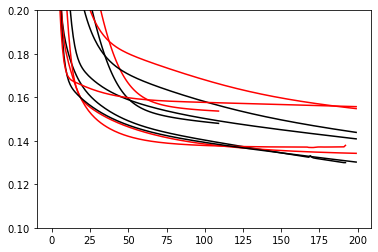

In [22]:
lr = 0.00001
wd = 0.1
for i in range(5):
    plt.plot(results[i][(lr, wd)]['train_loss'], c='black')
    plt.plot(results[i][(lr, wd)]['test_loss'], c='red')
plt.ylim([0.1,0.2])